In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
import pandas as pd
tf.__version__

'2.8.0'

In [88]:
# check whether GPU can be accessed 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [89]:
def PlotModelEval(Model, History, X, Y, Labels):
    
    # Scores for each class (can be interpreted as probabilities since we use softmax output)
    S = Model.predict(X)
    # Prediction (class number) for each test image
    P = np.expand_dims(np.argmax(S,axis=1), axis=-1)
    # Calculate confusion matrix
    CM = confusion_matrix(Y,P)
    
    # Plot training history
    plt.figure(figsize=(16,6))
    plt.subplot(2,2,1)
    plt.semilogy(History.history['loss'], label="Training")
    if 'val_loss' in History.history:
        plt.semilogy(History.history['val_loss'], label="Validation")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, which="both")
    plt.subplot(2,2,3)
    plt.plot(100 * np.array(History.history['accuracy']), label="Training")
    if 'val_accuracy' in History.history:
        plt.plot(100 * np.array(History.history['val_accuracy']), label="Validation")
    plt.title('Model accuracy')
    plt.ylabel('Acc [%]')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True, which="both")
    
    # Plot confusion matrix
    plt.subplot(2,2,(2,4)) # assign plot to both slots
    PlotConfusionMatrix(CM, classes=Labels, title="Confusion matrix (test)")
    plt.show()

# ============================================================================

def PlotConfusionMatrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        showAcc=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if showAcc:
        acc = 100*(np.trace(cm) / np.sum(cm))
        title = title + " | Acc=%.2f%%" % acc
        
    plt.title(title)

# ============================================================================

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [90]:
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

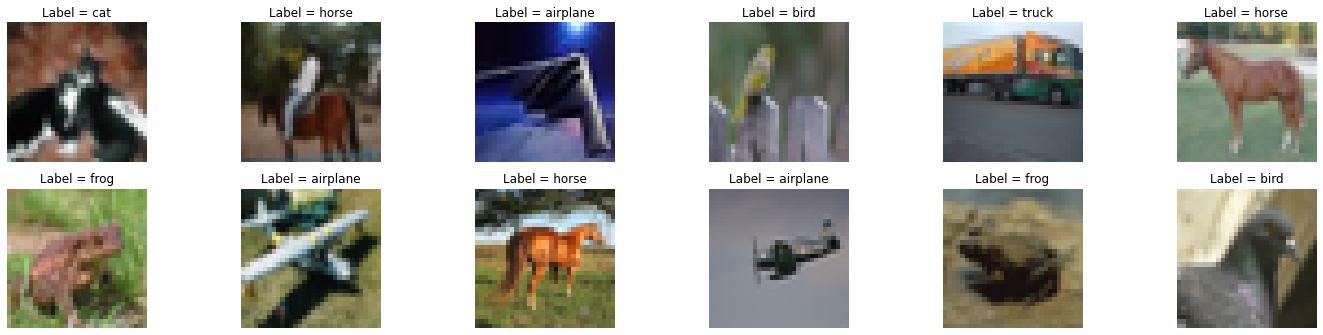

In [91]:
plt.figure(figsize=(20,5))
for i in range(12):
    idx = np.random.randint(0, len(y_train))
    label = y_train[idx,0]
    
    plt.subplot(2,6,i+1)
    plt.tight_layout()
    plt.imshow(X_train[idx])
    plt.title("Label = {}".format(cifar_labels[label]))
    plt.axis('off')
plt.show()

In [92]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=90,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True)
#datagen.fit(X_train)
flow = datagen.flow(X_train, y_train, batch_size=9) # Set Batch-size

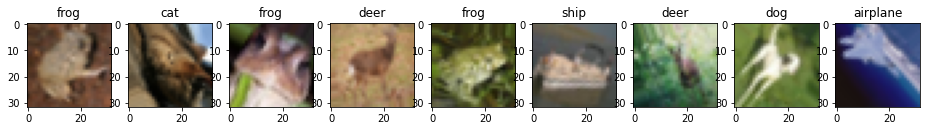

In [96]:
rnd_img_batch = flow.next()

plt.figure(figsize=(16, 64))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image, label = rnd_img_batch[0][i], rnd_img_batch[1][i]
    plt.imshow(image)
    plt.title(cifar_labels[np.argmax(label)])

In [97]:
idX = round(0.2*X_train.shape[0])
X_val, X_train = X_train[:idx, ], X_train[idx:, ]
y_val, y_train = y_train[:idx, ], y_train[idx:, ]

In [105]:
!wandb login "8ecf7403a425fa8a096aeedbe252d23586e2a4cc"

wandb: Appending key for api.wandb.ai to your netrc file: /Users/patrickhiemsch/.netrc


In [106]:
i=1

In [108]:
import wandb
from wandb.keras import WandbCallback

num_classes = 10

# initialize run with hyperparameters 
batch_size = 64
epochs = 50
learning_rate = 0.005


wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
}

wandb.init(project="CIFAR10-Classification", 
           entity="patricksvm",
           config=wandb.config,
           name = f"CIFAR-Run-{i}")

i+=1

wandb: Currently logged in as: patricksvm. Use `wandb login --relogin` to force relogin


In [109]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler





model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

#data augmentation
datagen = ImageDataGenerator(rotation_range=30,
                          width_shift_range=0.1, 
                          height_shift_range=0.1,
                          horizontal_flip=True)

#training
batch_size = 64
flow_train = datagen.flow(X_train, y_train, batch_size=batch_size)



model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), metrics=['accuracy'])
hist = model.fit(flow_train,
          steps_per_epoch=(X_train.shape[0]) // batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_30 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_35 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_31 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_36 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

2022-08-10 21:33:06.966775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


680/680 [==============================] - ETA: 0s - loss: 1.5026 - accuracy: 0.4627

2022-08-10 21:34:04.940223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


680/680 [==============================] - 63s 90ms/step - loss: 1.5026 - accuracy: 0.4627 - val_loss: 1.4476 - val_accuracy: 0.5270
Epoch 2/50
680/680 [==============================] - 56s 83ms/step - loss: 1.1117 - accuracy: 0.6080 - val_loss: 1.1540 - val_accuracy: 0.6182
Epoch 3/50
680/680 [==============================] - 59s 86ms/step - loss: 0.9760 - accuracy: 0.6578 - val_loss: 0.8322 - val_accuracy: 0.7134
Epoch 4/50
680/680 [==============================] - 57s 85ms/step - loss: 0.8925 - accuracy: 0.6884 - val_loss: 0.7842 - val_accuracy: 0.7252
Epoch 5/50
680/680 [==============================] - 58s 86ms/step - loss: 0.8366 - accuracy: 0.7080 - val_loss: 0.6605 - val_accuracy: 0.7757
Epoch 6/50
680/680 [==============================] - 57s 84ms/step - loss: 0.7958 - accuracy: 0.7260 - val_loss: 0.7162 - val_accuracy: 0.7601
Epoch 7/50
680/680 [==============================] - 57s 84ms/step - loss: 0.7610 - accuracy: 0.7362 - val_loss: 0.6282 - val_accuracy: 0.7864
Epo




========== lr: 0.005 ==========




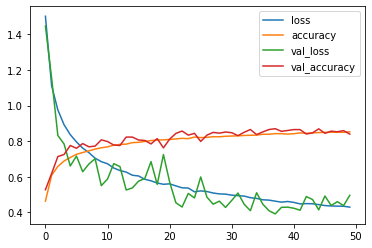

Test loss = 0.539
Test accuracy = 0.826


In [110]:
print(f"\n\n\n========== lr: {learning_rate} ==========")
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print("\n")
pd.DataFrame(hist.history).plot()
plt.show()
for i in range(len(score)):
      print("Test " + model.metrics_names[i] + " = %.3f" % score[i])
